In [1]:
%matplotlib inline

import gzip
import pickle
from urllib.request import urlretrieve
import zipfile

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

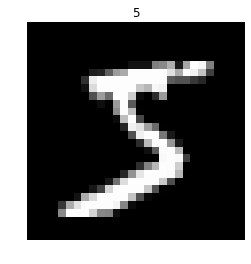

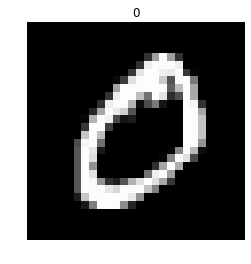

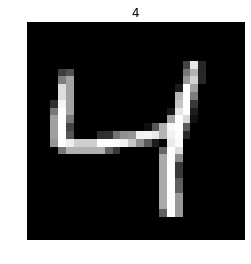

In [2]:
urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz",
            "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz") as f:
    train_data, _, test_data = pickle.load(f, encoding="latin1")
train_data = list(train_data)
test_data = list(test_data)
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot

for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_data[0][i], (28, 28)),
               cmap="gray")
    plt.axis('off')
    plt.title(str(np.argmax(train_data[1][i])));

In [3]:
with nengo.Network() as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    neuron_type = nengo.LIF(amplitude=0.01)

    nengo_dl.configure_settings(trainable=False)

    inp = nengo.Node(np.zeros(784))

    temp = nengo.Probe(inp)

    
    #x0, conn0 = nengo_dl.tensor_layer(inp, neuron_type,
    #                                  transform=nengo_dl.dists.Glorot(),
    #                                 shape_in=(256,), return_conn=True)

    x0 = nengo.Ensemble(784, 1, neuron_type = neuron_type)
    weights_in = np.zeros((784,784))
    for j in range(784):
        weights_in[j][j] = 1
    conn0 = nengo.Connection(inp, x0.neurons,transform=weights_in,synapse=None)
    #net.config[x0].trainable = True
    #net.config[conn0].trainable = True

    x1, conn1 = nengo_dl.tensor_layer(x0, neuron_type,
                                      transform=nengo_dl.dists.Glorot(),
                                      shape_in=(64,), return_conn=True)

    #net.config[x1].trainable = True
    net.config[conn1].trainable = True

    x = nengo.Node(size_in=10)
    conn = nengo.Connection(x1, x, transform=nengo_dl.dists.Glorot(),
                         synapse=None)

    net.config[conn].trainable = True

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(x)
    out_p_filt = nengo.Probe(x, synapse=0.1)


In [4]:
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
|#                         Optimizing graph                           | 0:00:00

/anaconda3/lib/python3.7/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Optimization finished in 0:00:00                                               
|#                        Constructing graph                          | 0:00:00WARNING:tensorflow:From /anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Construction finished in 0:00:01                                               #########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [5]:
# add the single timestep to the training data
train_data = {inp: train_data[0][:, None, :],
              out_p: train_data[1][:, None, :]}

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps. we're also going to reduce the number of test images, just
# to speed up this example.
n_steps = 30
test_data = {
    inp: np.tile(test_data[0][:minibatch_size*2, None, :],
                 (1, n_steps, 1)),
    out_p_filt: np.tile(test_data[1][:minibatch_size*2, None, :],
                        (1, n_steps, 1))}

In [6]:
def objective(outputs, targets):
    return tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=outputs, labels=targets)

In [7]:
opt = tf.train.RMSPropOptimizer(learning_rate=0.001)

In [8]:
def classification_error(outputs, targets):
    return 100 * tf.reduce_mean(
        tf.cast(tf.not_equal(tf.argmax(outputs[:, -1], axis=-1),
                             tf.argmax(targets[:, -1], axis=-1)),
                tf.float32))


print("error before training: %.2f%%" % sim.loss(
    test_data, {out_p_filt: classification_error}))

|####################Calculating loss (100%)###################| ETA:  00:00:00WARNING:tensorflow:From /anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Calculation finished in 0:00:01                                                
error before training: 91.75%


In [9]:
do_training = True
if do_training:
    # run training
    sim.train(train_data, opt, objective={out_p: objective}, n_epochs=10)

    # save the parameters to file
    sim.save_params("./mnist_params_3l")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1u9JyNuRxQDUcFgkRnI1qfJVFMdnGRsjI",
        "mnist_params.zip")
    with zipfile.ZipFile("mnist_params.zip") as f:
        f.extractall()

    # load parameters
    sim.load_params("./mnist_params")

|                   Training (0%)                  | ETA:  --:--:-- (loss: ---)WARNING:tensorflow:From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Training finished in 0:00:51 (loss: 15.5165)                                   


In [10]:
print("error after training: %.2f%%" % sim.loss(
    test_data, {out_p_filt: classification_error}))

Calculation finished in 0:00:01                                                
error after training: 4.00%


In [11]:
sim.run_steps(n_steps, data={inp: test_data[inp][:minibatch_size]})

for i in range(1):
    print(sim.data[conn0].weights.shape) 
    print(sim.data[conn0].weights) 
    print(sim.data[conn1].weights.shape)
    print(sim.data[conn].weights.shape)
    with open('weights1.txt', 'w') as f:
        print(sim.data[conn1].weights, file=f)
    with open('weights2.txt', 'w') as fname:
        print(sim.data[conn].weights, file=fname)
        #print(sim.data[temp][i], file=f)

Simulation finished in 0:00:01                                                 
(784, 784)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(64, 784)
(10, 64)


sim.run_steps(n_steps, data={inp: test_data[inp][:minibatch_size]})

for i in range(5):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(test_data[inp][i, 0], (28, 28)),
               cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(sim.trange(), sim.data[out_p_filt][i])
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("time")